In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

np.random.seed(42)

In [66]:
def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['wind_speed'] = data.hum_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    
    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    
    for c in data.columns:
        data[c].fillna((data[c].bbmean()), inplace=True)
    
    return data

In [67]:
class Chunk:
    def __init__(self, train_part, test_part, feature_names):
        self.train = train_part
        self.test = test_part
        self.features = feature_names
        
    def get_X(self, forvard_time):
        X = list(self.train.P1.values)
        #for feature in self.features:
        #    X.append(self.test[feature].values[forvard_time])
        return X
    
    def get_y(self, forward_time):
        y = self.test.P1.values[forward_time]
        return y

        
    def get_meta_X(self, forward_time, models):
        X = self.get_X(forward_time)
        model = models[forward_time]
        prediction = model.predict([X])[0]
        X_meta = [prediction]
        for feature in self.features:
            X_meta.append(self.test[feature].values[forward_time])
        return X_meta
        
        

In [68]:
def prepare_data(data):
    data['P1'] = data.P1.interpolate()
    data['pressure'] = data.pressure.interpolate()
    data['humidity'] = data.humidity.interpolate()
    data['temperature'] = data.temperature.interpolate()
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data['prec_time'] = data.prec_time.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)
    data['prec_amount'] = data.prec_amount//data.prec_time
    data['prec_time'] = data.prec_time.interpolate()
    data['prec_amount'] = data.prec_amount.interpolate()
    return data

In [69]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [70]:
sel_columns = ['P1', 'pressure', 'temperature', 'humidity', 'wind_direction',
               'wind_speed', 'prec_amount', 'prec_time']
data = data[sel_columns]

In [71]:
data = prepare_data(data)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108001 entries, 2019-04-01 00:00:00+00:00 to 2020-04-10 00:00:00+00:00
Data columns (total 8 columns):
P1                108001 non-null float64
pressure          108001 non-null float64
temperature       108001 non-null float64
humidity          108001 non-null float64
wind_direction    108001 non-null object
wind_speed        108001 non-null int64
prec_amount       108001 non-null float64
prec_time         108001 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.4+ MB


In [73]:
train_data = data[:str(data.index[-1] - datetime.timedelta(days=50))]
test_data = data[str(data.index[-1] - datetime.timedelta(days=50)):]

In [74]:
def pp(start, end, n):
    """generation of random datetime indexes"""
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [75]:
def generate_chunks(series, n, start, end, chunk_len, test_len, features):
    chunks = []
    for idx in pp(start, end, n):
        train_part = series[str(idx):str(idx+datetime.timedelta(hours=chunk_len-test_len))]
        test_part = series[str(idx+datetime.timedelta(hours=chunk_len-test_len)):str(idx+datetime.timedelta(hours=chunk_len))]
        chunk = Chunk(train_part, test_part, features)
        chunks.append(chunk)
    return chunks

In [76]:
chunk_len = 48
test_len = 24
train_start_idx = train_data.index[0]
train_end_idx = train_data.index[-1] - datetime.timedelta(hours=chunk_len)
train_num_samples = 2000

train_chunks = generate_chunks(train_data.resample('1H').mean(), train_num_samples,
                         train_start_idx, train_end_idx,
                         chunk_len, test_len,
                         ['pressure', 'temperature', 'humidity', 'wind_speed', 'prec_amount']
                        )

test_start_idx = test_data.index[0]
test_end_idx = test_data.index[-1] - datetime.timedelta(hours=chunk_len)
test_num_samples = 300

test_chunks = generate_chunks(test_data.resample('1H').mean(), test_num_samples,
                         test_start_idx, test_end_idx,
                         chunk_len, test_len,
                         ['pressure', 'temperature', 'humidity', 'wind_speed', 'prec_amount']
                        )

In [77]:
train, train_meta = train_test_split(train_chunks, test_size=0.5, random_state=42)

In [78]:
def train_models(model, chunks, num_models):
    models = []
    for i in range(num_models):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = clone(model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        models.append(local_model)
    return models

In [79]:
def get_mae(models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [80]:
len(train)

1000

In [81]:
#mod = RandomForestRegressor(min_samples_leaf=3, random_state=42)
mod = Lasso(alpha=0.2, random_state=42)
models = train_models(mod, train, test_len)

In [82]:
mae = get_mae(models, test_chunks)

In [83]:
def train_meta_models(meta_model, models, chunks, num_models):
    meta_models = []
    for i in range(num_models):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = clone(meta_model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        meta_models.append(local_model)
    return meta_models

In [84]:
def get_meta_mae(models, meta_models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [85]:
%%time
#meta_model = Lasso(alpha=0.2, random_state=42)
#meta_model = Ridge(alpha=0.6, random_state=42)
meta_model = RandomForestRegressor(min_samples_leaf=3, random_state=42)
meta_models = train_meta_models(meta_model, models, train_meta, test_len)

CPU times: user 10.7 s, sys: 20.1 ms, total: 10.7 s
Wall time: 10.9 s


In [86]:
meta_mae = get_meta_mae(models, meta_models, test_chunks)

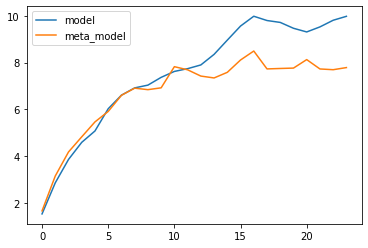

In [87]:
plt.plot(mae, label='model')
plt.plot(meta_mae, label='meta_model')
plt.legend()

In [88]:
meta_mae

[1.6597317506069424,
 3.1512766404138484,
 4.17794967688043,
 4.824718850689107,
 5.4625777832841935,
 5.90956125170259,
 6.5989594404150544,
 6.9040991545064605,
 6.840313087350634,
 6.9185036898485,
 7.822520229217762,
 7.688852431708018,
 7.420956330033443,
 7.340614074197501,
 7.580863958934551,
 8.10790619915932,
 8.491094517609875,
 7.726503827330968,
 7.745487711299748,
 7.761911608233047,
 8.124487092072888,
 7.724859643164232,
 7.693157835163535,
 7.783580105814047]

In [89]:
mae

[1.5303334648485243,
 2.860072633294068,
 3.8579084561745307,
 4.589297893348252,
 5.074898712085396,
 6.024796823814074,
 6.604481885154752,
 6.915798290919205,
 7.034136466259636,
 7.366144729020866,
 7.619512293723447,
 7.737177342188422,
 7.8967780167882715,
 8.348278147991477,
 8.957075546792439,
 9.558624944934245,
 9.977638150552787,
 9.794864764365249,
 9.713632194542098,
 9.463442019946337,
 9.306396748289393,
 9.522542923830905,
 9.806327794914527,
 9.97448312082947]

In [64]:
meta_mae

[1.6324263688290035,
 2.9721436793234917,
 4.004207466324041,
 5.070850273097633,
 5.668973765171288,
 6.151796103164654,
 6.498035192752712,
 6.050173309343109,
 6.3162512424415596,
 6.952209406687157,
 7.56656560135368,
 7.527331410210847,
 7.190080318744304,
 7.188581400287322,
 7.100921425739322,
 7.237364994922945,
 7.400772285077928,
 7.21631464286128,
 7.334948247954983,
 7.5763192022420816,
 7.79126995984484,
 8.346891163227328,
 8.871815118982623,
 8.9771874934208]

In [65]:
mae

[1.5528074613292229,
 2.8249413640331658,
 3.8313263718457606,
 4.910559313108432,
 5.647163666627384,
 6.262770362338649,
 6.7800540095689925,
 6.864197378928881,
 6.615627099889851,
 6.850907389389878,
 7.33106854061523,
 7.35676418811937,
 7.313839403933052,
 7.5478201978120465,
 7.846376825612173,
 8.072709773719968,
 8.587310914200614,
 8.60980152358342,
 8.597134231649715,
 8.520609398225181,
 8.713672303082195,
 9.15845631591762,
 9.742700047197674,
 9.914087454875007]

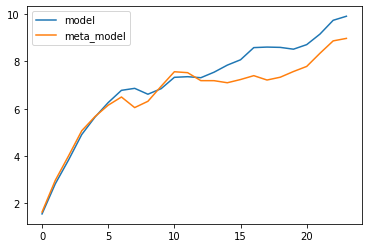

In [63]:
plt.plot(mae, label='model')
plt.plot(meta_mae, label='meta_model')
plt.legend()